# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [3]:
def add_features(df):
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)
    df['blueHerald'] = (df['blueEliteMonsters'] - df['blueDragons']).clip(lower=0)
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']
    df['dragonKillImpact'] = df['blueDragons'] / (df['blueKills'] + 1)
    df['eliteMonsterUtilization'] = df['blueEliteMonsters'] / (df['blueKills'] + df['blueAssists'] + 1)
    df['goldExperienceRatio'] = df['blueTotalGold'] / (df['blueTotalExperience'] + 1)
    df['teamEfficiency'] = (df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']) / (df['blueDeaths'] + 1)
    df['killToMonsterRatio'] = df['blueKills'] / (df['blueEliteMonsters'] + 1)
    df['avgGoldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)
    df['expToKillRatio'] = df['blueTotalExperience'] / (df['blueKills'] + 1)
    df['killsMinusDeaths'] = df['blueKills'] - df['blueDeaths']
    df['killDeathRatio'] = df['blueKills'] / (df['blueKills'] + df['blueDeaths'])
    df['avgExperiencePerKill'] = df['blueTotalExperience'] / df['blueKills']

    return df

- Apply data

In [4]:
train = add_features(train)
test = add_features(test)

# 特徴量の効き

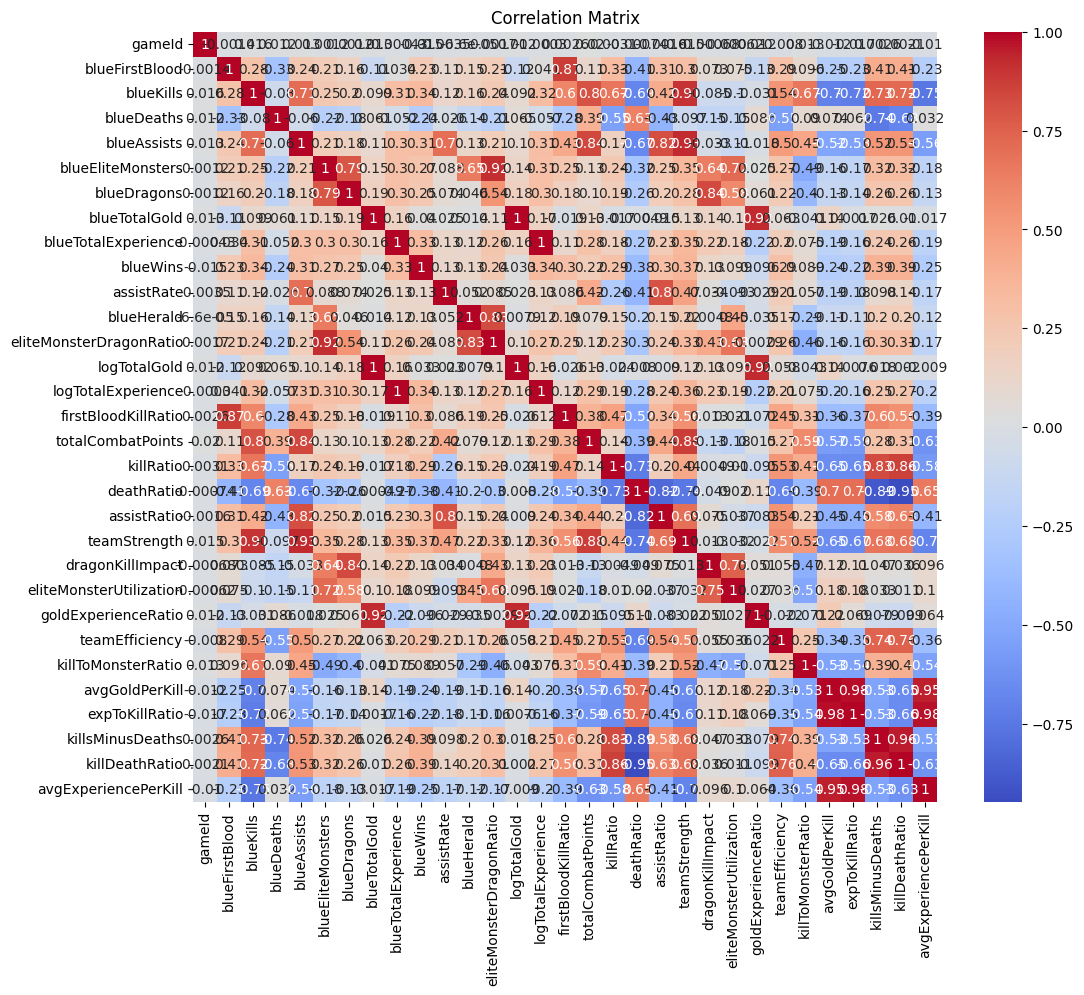

In [5]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- LightGBM

In [6]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

# Optunaでのハイパーパラメータチューニング
def objective(trial):
    # param = {
    #     'objective': 'binary',
    #     'metric': 'binary_error',
    #     'verbosity': -1,
    #     'boosting_type': 'gbdt',
    #     'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    #     'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    #     'num_leaves': trial.suggest_int('num_leaves', 2, 256),
    #     'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
    #     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    #     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    # }

    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',  # 他のタイプも試すことができます
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),  # 小さな値に調整
        'max_depth': trial.suggest_int('max_depth', 5, 15),  # 深さを制限
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # 学習率を微調整
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),  # サンプル数を増やす
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),  # L1 正則化を強化
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),  # L2 正則化を強化
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
    }
        

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=100, verbose=False)
    model = lgb.train(param, lgb_train, num_boost_round=5000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X_train, y_train)
model = lgb.train(best_params, lgb_train, num_boost_round=study.best_trial.number)

[I 2024-01-22 13:43:19,942] A new study created in memory with name: no-name-4121be6b-24c4-47d9-86d0-7ccc3463b9f7
[I 2024-01-22 13:43:20,252] Trial 0 finished with value: 0.80625 and parameters: {'num_leaves': 39, 'max_depth': 6, 'learning_rate': 0.04023444702784562, 'min_child_samples': 69, 'subsample': 0.7975697198866294, 'colsample_bytree': 0.7571619505929508, 'reg_alpha': 0.028792568086081945, 'reg_lambda': 0.005433731982663279, 'feature_fraction': 0.7832707176475991, 'bagging_fraction': 0.6985965945772084, 'bagging_freq': 6}. Best is trial 0 with value: 0.80625.
[I 2024-01-22 13:43:20,363] Trial 1 finished with value: 0.80375 and parameters: {'num_leaves': 70, 'max_depth': 7, 'learning_rate': 0.17590767062707915, 'min_child_samples': 53, 'subsample': 0.9863011716464107, 'colsample_bytree': 0.64201224495324, 'reg_alpha': 0.0013028245865131809, 'reg_lambda': 0.12041250087496537, 'feature_fraction': 0.7643496237613017, 'bagging_fraction': 0.9274584289926407, 'bagging_freq': 3}. Best 

- val_accuracy確認

In [7]:
# バリデーションに対する予測
y_val_pred = model.predict(X_val)
y_val_pred_int = (y_val_pred > 0.5).astype(int)
print(f'val_accuracy: {accuracy_score(y_val, y_val_pred_int)}')

val_accuracy: 0.804375


- testにy_test_pred結合

In [8]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_submit_cv_oputuna_val{accuracy_score(y_val, y_val_pred_int):.4f}.csv'

In [9]:
# テストデータに対する予測
y_test_pred = model.predict(test_drop_gameId)
y_test_pred_int = (y_test_pred > 0.5).astype(int)

# 予測結果の表示
print(y_test_pred_int)


submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_int
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

[1 1 1 ... 1 1 0]


- 出力csvチェック

In [10]:
check = pd.read_csv(output)

In [11]:
check

,9,1
0,15,1
1,18,1
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
